# 实验四：朴素贝叶斯分类器
- 学号：2013750
- 姓名：管昀玫
- 专业：计算机科学与技术

## 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

In [1]:
import math
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
f = open('wine.data', 'r')
types = [[], [], []]                      # 按类分的所有数据
test_data = [[], [], []]
train_data = [[], [], []]
data_num = 0                            # 数据总数
test_len = []                           # 测试集里每一类的个数
means = [[], [], []]                      # 每一类的均值
std = [[], [], []]                        # 每一类的标准差
myline = '1'
while myline:
    myline = f.readline().split(',')
    if len(myline) != 14:
        break
    for t in range(len(myline)):
        if t == 0:
            myline[t] = int(myline[t])
        else:
            myline[t] = float(myline[t])
    temp = myline.pop(0)
    types[temp - 1].append(myline)
test_len = [round(len(types[i]) / 10) for i in range(3)]
data_num = sum([len(types[i]) for i in range(3)])

我的混淆矩阵是相对于每一个类别而言的，每一个类有2\*2的混淆矩阵，有三个类

In [35]:
TP = [0, 0, 0]
FN = [0, 0, 0]
FP = [0, 0, 0]
TN = [0, 0, 0]
precision = [0, 0, 0]
recall = [0, 0, 0]
fp_rate = [[0.0], [0.0], [0.0]]
tp_rate = [[0.0], [0.0], [0.0]]
F_measure = [0, 0, 0]
accuracy = [0, 0, 0]
threshold = 1e-18
p_value = [[], [], []]
label = [[], [], []]
prediction = [[], [], []]

In [5]:
def Bayes(data, p, avg, var):
    result = p
    for i in range(len(data)):
        result *=  1 / (np.sqrt(2 * math.pi)* var[i]) * np.exp(-((data[i] - avg[i]) ** 2) / (2 * var[i]))
    return result

$P(c|x)$：后验概率（在给定样本$x$的条件下，属于类别$c$的概率）。

$P(x|c)$：假设在$c$类下，观察到样本$x$的概率。模式特征$𝑥$的似然函数（特征$x$来自于类别$c$的可能性）。

$P(c)$：样本为类别$c$的先验概率。在实际应用中，先验概率都是未知的，只能通过背景知识、训练数据等来估计这些概率。这也是贝叶斯方法的难处之一。本题将其视为正态分布，其概率密度公式为$f(x) = \frac{1}{\sqrt{2 \pi}\sigma}e^{-\frac{(\theta-u)^2}{2\sigma. ^2}}$

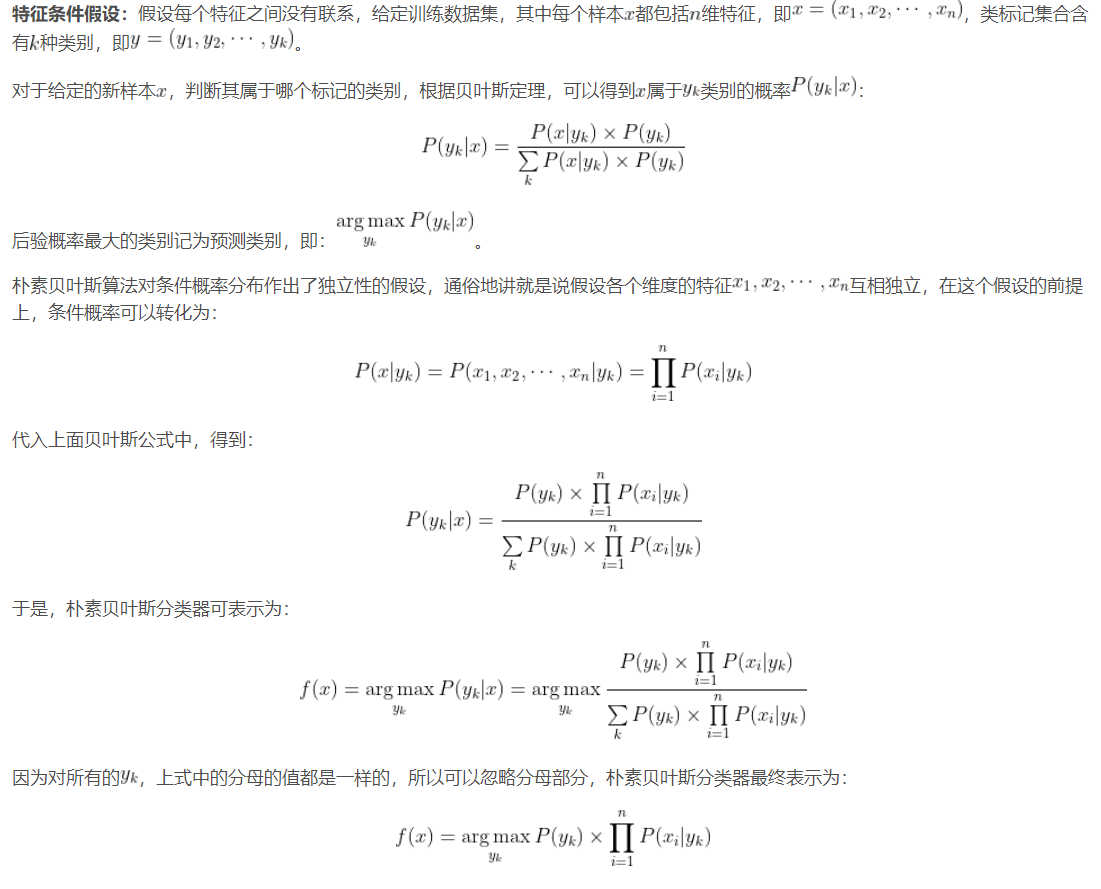

- 朴素贝叶斯只适用于特征之间是条件独立的情况下，否则分类效果不好，这里的朴素指的就是条件独立。
- 朴素贝叶斯主要被广泛地使用在文档分类中。
这里为了方便计算(np.mat()出了点问题)，将所有的式子都取对数。因此，连乘变成连加，其余变成log，之后再使用exp还原

In [37]:
def bayes_classificate():
    # 首先，分别计算训练集上三个类的均值和标准差
    # mean = ...
    # std = ...
    total = 0
    for i in range(3):
        means[i] = np.mean(train_data[i], axis=0)  # 分别计算三个类别的均值
        std[i] = np.std(train_data[i], axis=0)  # 标准差
        total += train_data[i].shape[0]
    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:   # 两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                # 由于数据集中所有的属性都是连续值，连续值的似然估计可以按照高斯分布来计算：
                # 这里为了方便计算，将整个式子都取对数处理，连乘变成+，常数项变成log
                temp = np.log((2*math.pi) ** 0.5 * std[j]) + np.power(t - means[j], 2) / (2 * np.power(std[j], 2))
                temp = np.sum(temp)
                temp = -1*temp+math.log(len(types[j])/data_num)
                my_type.append(temp)    # 这里将所有score保存
            pre_type = my_type.index(max(my_type))  # 取分值最大的为预测类别
            p_value[i].append(max(my_type))
            label[i].append(i)
            
            prediction[i].append(pre_type)
            if math.exp(max(my_type)) > threshold: 
                if pre_type == i:
                    # tp_rate[i].append(tp_rate[i][-1] + 1)
                    # fp_rate[i].append(fp_rate[i][-1])
                    TP[i] += 1
                else:
                    # tp_rate[i].append(tp_rate[i][-1])
                    # fp_rate[i].append(fp_rate[i][-1] + 1)
                    FP[i] += 1
            else:
                if pre_type == i:
                    FN[i] += 1
                else:
                    TN[i] +=1
            if pre_type != i:  # 统计错误数
                wrong_num += 1
    return wrong_num

分层抽样，并按照9:1划分训练集和测试集，输出分类准确率

In [38]:
wrong_cnt = [0, 0, 0]
for i in range(10): # 数据集划分9:1，分层抽样
    for j in range(3):
        if (i+1) * test_len[j] > len(types[j]):
            test_data[j] = np.mat(types[j][i * test_len[j]:])
            train_data[j] = np.mat(types[j][:i * test_len[j]])
        else:
            test_data[j] = np.mat(types[j][i * test_len[j]:(i+1) * test_len[j]])
            train_data[j] = np.mat(types[j][:i * test_len[j]]+types[j][(i+1) * test_len[j]:])
    wrong_cnt[j] += bayes_classificate()
print("分类准确率: "+str(1 - sum(wrong_cnt)/data_num))

分类准确率: 0.9775280898876404


## 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

- True Positive（TP）：真正类。样本的真实类别是正类，并且模型识别的结果也是正类。
- False Negative（FN）：假负类。样本的真实类别是正类，但是模型将其识别为负类。
- False Positive（FP）：假正类。样本的真实类别是负类，但是模型将其识别为正类。
- True Negative（TN）：真负类。样本的真实类别是负类，并且模型将其识别为负类。
- 精确率(Accuracy: $Accuracy = (TP+TN)/(TP+FN+FP+TN)$
- 准确率(Precision): $Precision = TP/(TP+FP)$
- 召回率(Recall): $Recall = TP/(TP+FN)$
- F1-score: $ F_1 = 2 \frac{precision*recall}{precision + recall}$

此处的混淆矩阵是相对于每一个类别而言。例如，TP[i]就是第i类的TP值，FN[i]就是第i类的FN值。对于每一个类，分别输出进度、召回率、准确率、F值。

In [39]:
for i in range(3):
    # FP[i] = FP[i] - TP[i]
    precision[i] = TP[i] / (TP[i] + FP[i])
    recall[i] = TP[i] / (TP[i] + FN[i])
    accuracy[i] = (TP[i] + TN[i]) / (TP[i] + FN[i] + FP[i] + TN[i])
    # F_measure[i] = 2 / (1 / precision[i] + 1 / recall[i])
    F_measure[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
print("TP: ", TP)
print("FN: ", FN)
print("FP: ", FP)
print("TN: ", TN)
for i in range(3):
    print("Class:  ", i+1)
    # print("fp_rate: ", fp_rate[i], "tp_rate: ", tp_rate[i])
    print("precision: ", precision[i], "recall: ", recall[i])
    print("accuracy: ", accuracy[i], "F_measure: ", F_measure[i])

TP:  [57, 67, 47]
FN:  [0, 1, 1]
FP:  [2, 2, 0]
TN:  [0, 0, 0]
Class:   1
precision:  0.9661016949152542 recall:  1.0
accuracy:  0.9661016949152542 F_measure:  0.9827586206896551
Class:   2
precision:  0.9710144927536232 recall:  0.9852941176470589
accuracy:  0.9571428571428572 F_measure:  0.9781021897810219
Class:   3
precision:  1.0 recall:  0.9791666666666666
accuracy:  0.9791666666666666 F_measure:  0.9894736842105264


## 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

将每一类测试样本按照p值排序。类似于爬楼梯的思路：排序后，从第一个到最后一个样本，如果预测值与真实值相同，则往上走一格；否则向右走一格。

In [40]:
def fp_tp():
    for i in range(3):
        for j in np.argsort(p_value[i])[::-1]:
            if label[i][j] == prediction[i][j]:
                tp_rate[i].append(tp_rate[i][-1] + 1)
                fp_rate[i].append(fp_rate[i][-1])
            else:
                tp_rate[i].append(tp_rate[i][-1])
                fp_rate[i].append(fp_rate[i][-1] + 1)
    for i in range(3):
        tp_rate[i] = [x/tp_rate[i][-1] for x in tp_rate[i]]
        fp_rate[i] = [x/fp_rate[i][-1] if fp_rate[i][-1]!= 0 else x for x in fp_rate[i]]
        if fp_rate[i][-1] == 0.0:
            fp_rate[i].append(1.0)
            tp_rate[i].append(1.0)
        #temp = 0
        #temp = AUC(label[i], p_value[i], i)
        #print("类别为:", i+1, "auc值为: ", temp)
    plt.plot(fp_rate[0], tp_rate[0], 'b')
    plt.plot(fp_rate[1], tp_rate[1], 'b')
    plt.plot(fp_rate[2], tp_rate[2], 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()

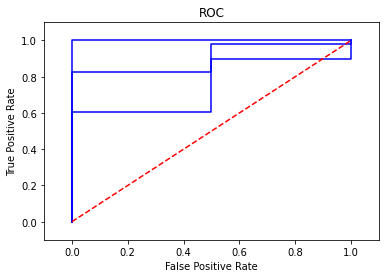

In [41]:
fp_tp()

计算AUC值：
AUC (Area Under Curve) 被定义为ROC曲线下的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围一般在0.5和1之间。使用AUC值作为评价标准是因为很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而作为一个数值，对应AUC更大的分类器效果更好。

In [47]:
for i in range(3):
    auc = 0
    for j in range(1, len(fp_rate[i])):
        # 算下方面积
        auc += 0.5 * (fp_rate[i][j] - fp_rate[i][j - 1]) * (tp_rate[i][j] + tp_rate[i][j - 1])
    print("类别为: ", i, "auc值为: ", auc)

类别为:  0 auc值为:  0.9035087719298245
类别为:  1 auc值为:  0.75
类别为:  2 auc值为:  1.0


提供另一种画ROC曲线的思路：
首先，根据每个测试样本属于正样本的概率值从大到小排序。接下来，我们从高到低，依次将"Score"值作为阈值threshold，当测试样本属于正样本的概率大于或等于这个threshold时，我们认为它为正样本，否则为负样本。举例来说，假设第4个样本，其"Score"值为0.6，那么样本"Score"值大于它的第1，2，3，4都被认为是正样本，因为它们的"Score"值都大于等于0.6，而其他样本则都认为是负样本。每次选取一个不同的threshold，我们就可以得到一组FPR和TPR，即ROC曲线上的一点。这样一来，我们一共得到了若干组(本次实验为178组)FPR和TPR的值，将它们画在ROC曲线。
同时计算AUC值，即算曲线下方面积大小。

In [57]:
def draw_roc(pred_score,test_label,idx):
    fpr = []
    tpr = []
    # 计算fpr和tpr，阈值从大到小
    for i in np.argsort(pred_score)[::-1]:
        threshold = pred_score[i]
        if threshold == np.max(pred_score):
            fpr.append(0)
            tpr.append(0)
            continue
        elif threshold == np.min(pred_score):
            fpr.append(1)
            tpr.append(1)
            continue
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        m = np.argsort(pred_score)[::-1]
        for j in np.argsort(pred_score)[::-1]:
            if pred_score[j] >= threshold:
                if test_label[j] == idx:
                    tp += 1
                else:
                    fp += 1
            else:
                if test_label[j] == idx:
                    fn += 1
                else:
                    tn += 1
        fpr_temp = fp + tn
        tpr_temp = tp + fn
        if fpr_temp == 0: # 注意为0的情况
            fpr.append(0)
        else:
            fpr.append(fp / (fp + tn))
        if tpr_temp == 0:
            tpr.append(0)
        else:
            tpr.append(tp / (tp + fn))
    auc = 0
    for i in range(1, len(fpr)):
        auc += 0.5 * (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1])
    # print(fpr)
    # print(tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    return auc

画出ROC曲线并打印每一个分类的AUC值

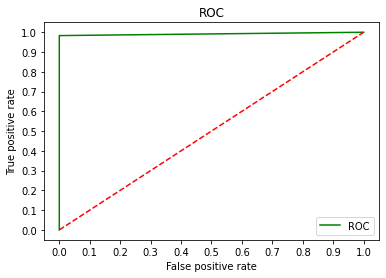

0.9915254237288136


In [58]:
res0 = draw_roc(p_value[0],label[0],0)
print(res0)

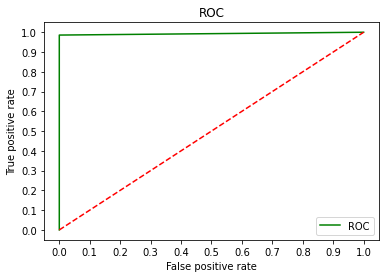

0.9928571428571429


In [59]:
res1 = draw_roc(p_value[1],label[1],1)
print(res1)

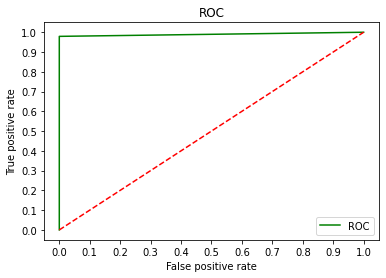

0.9895833333333333


In [60]:
res2 = draw_roc(p_value[2],label[2],2)
print(res2)